## Test against error

In [77]:
from quality_utils import *
import open3d as o3d
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [78]:
target = loadPCD("data/chair_target.ply")
target.paint_uniform_color([1, 0.706, 0])
source = loadPCD("data/chair_source.ply")
source.paint_uniform_color([0, 0.651, 0.929])
# o3d.visualization.draw_geometries([target, source])

PointCloud with 37744 points.

In [79]:
# trans_init = np.asarray([[0.0, 0.0, 1.0, 0.05], [1.0, 0.0, 0.0, -0.03],
#                              [0.0, 1.0, 0.0, 0.02], [0.0, 0.0, 0.0, 1.0]])
# source.transform(trans_init)
# o3d.visualization.draw_geometries([target, source])

In [80]:
voxel_size = 0.05

In [81]:
source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)

# Coarse registration
global_registration_result = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)

# Refine registration
refine_registration_result = refine_registration(source, target, source_fpfh, target_fpfh, voxel_size, global_registration_result.transformation)

:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.020.


In [82]:
# Find origins
source_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.03, origin=[0, 0, 0])
target_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.06, origin=[0, 0, 0])

# Transform the source origin
source_origin.transform(refine_registration_result.transformation)

# Visualize the point clouds and their origins
source_copy = copy.deepcopy(source) 
source_copy.transform(refine_registration_result.transformation)

o3d.visualization.draw_geometries([target, source_copy, source_origin, target_origin])

Alignment Quality:  0.8231078541218712


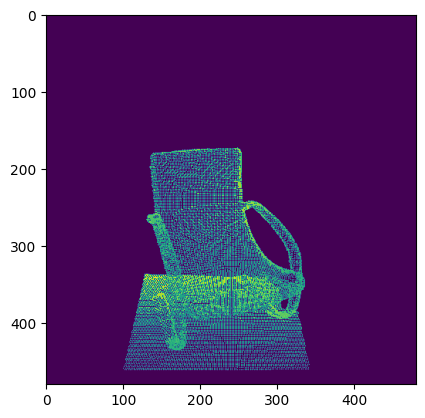

In [83]:
T = refine_registration_result.transformation
I11, I12, I21, I22 = get_projections(target, np.identity(4), source_copy, np.linalg.inv(T), save=False)

p = get_p(I11, I12, I21, I22, sigma=0.01)
print("Alignment Quality: ", p)

In [90]:
error = np.linspace(-1,1,101)
print("Error: ", error)

Error:  [-1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0.82 -0.8  -0.78
 -0.76 -0.74 -0.72 -0.7  -0.68 -0.66 -0.64 -0.62 -0.6  -0.58 -0.56 -0.54
 -0.52 -0.5  -0.48 -0.46 -0.44 -0.42 -0.4  -0.38 -0.36 -0.34 -0.32 -0.3
 -0.28 -0.26 -0.24 -0.22 -0.2  -0.18 -0.16 -0.14 -0.12 -0.1  -0.08 -0.06
 -0.04 -0.02  0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18
  0.2   0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38  0.4   0.42
  0.44  0.46  0.48  0.5   0.52  0.54  0.56  0.58  0.6   0.62  0.64  0.66
  0.68  0.7   0.72  0.74  0.76  0.78  0.8   0.82  0.84  0.86  0.88  0.9
  0.92  0.94  0.96  0.98  1.  ]


In [91]:
T = refine_registration_result.transformation

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [04:34<00:00,  2.72s/it]


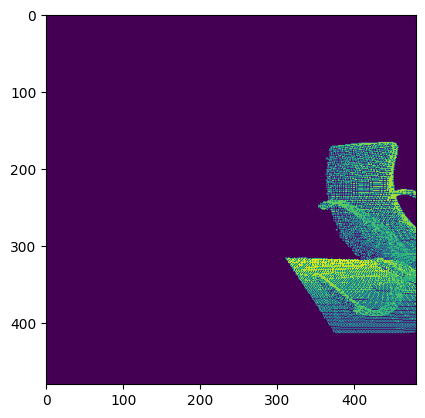

In [92]:
# Adding Error to X
quality_error_x = []

for e in tqdm(error):
    source_copy = copy.deepcopy(source) 
    source_copy.transform(refine_registration_result.transformation)

    source_copy.translate([e, 0, 0])
    I11, I12, I21, I22 = get_projections(target, np.identity(4), source_copy, np.linalg.inv(T), save=True)
    p = get_p(I11, I12, I21, I22, sigma=0.01)
    # print("Alignment Quality: ", p)
    quality_error_x.append(p)



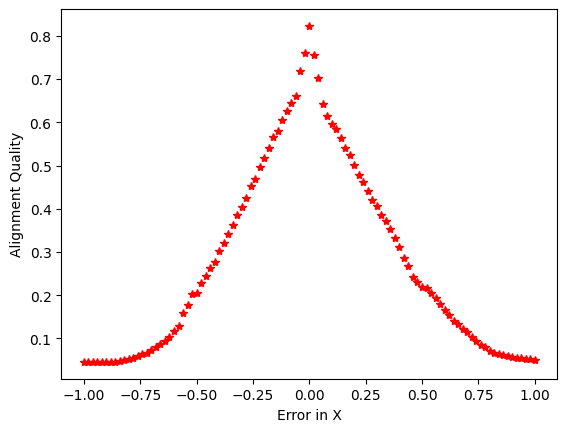

In [93]:
# Plot the results

plt.plot(error, quality_error_x, 'r*')
plt.xlabel('Error in X')
plt.ylabel('Alignment Quality')
plt.show()

100%|██████████| 101/101 [04:34<00:00,  2.72s/it]


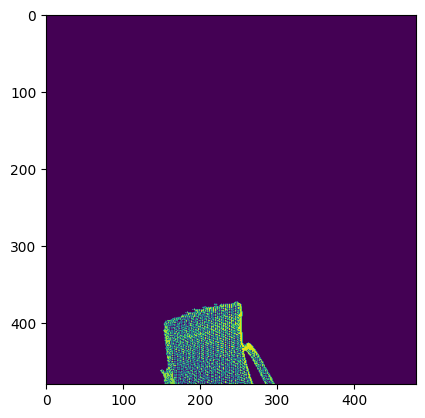

In [94]:
quality_error_y = []

for e in tqdm(error):
    source_copy = copy.deepcopy(source) 
    source_copy.transform(refine_registration_result.transformation)

    source_copy.translate([0, e, 0])
    I11, I12, I21, I22 = get_projections(target, np.identity(4), source_copy, np.linalg.inv(T), save=True)
    p = get_p(I11, I12, I21, I22, sigma=0.01)
    # print("Alignment Quality: ", p)
    quality_error_y.append(p)

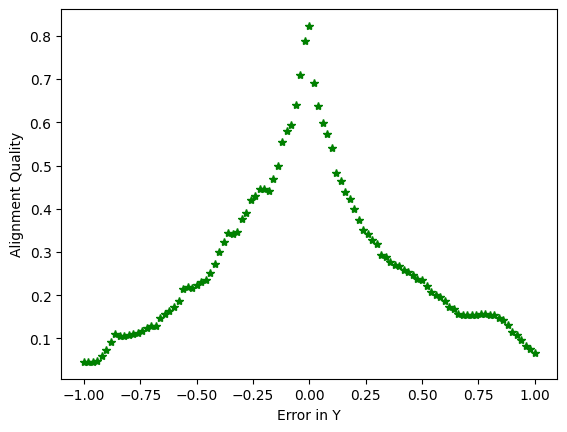

In [95]:
# Plot the results

plt.plot(error, quality_error_y, 'g*')
plt.xlabel('Error in Y')
plt.ylabel('Alignment Quality')
plt.show()

100%|██████████| 101/101 [04:33<00:00,  2.71s/it]


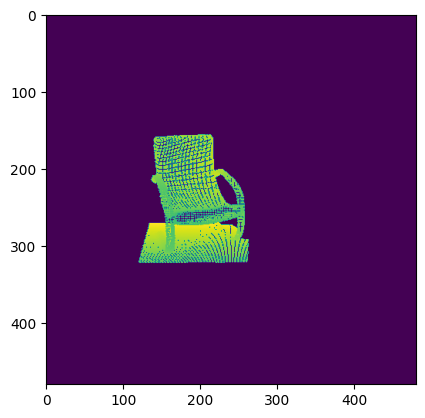

In [96]:
quality_error_z = []

for e in tqdm(error):
    source_copy = copy.deepcopy(source) 
    source_copy.transform(refine_registration_result.transformation)

    source_copy.translate([0, 0, e])
    I11, I12, I21, I22 = get_projections(target, np.identity(4), source_copy, np.linalg.inv(T), save=True)
    p = get_p(I11, I12, I21, I22, sigma=0.01)
    # print("Alignment Quality: ", p)
    quality_error_z.append(p)

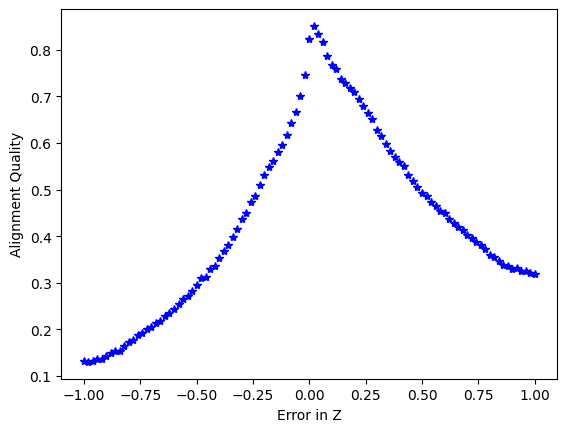

In [97]:
# Plot the results

plt.plot(error, quality_error_z, 'b*')
plt.xlabel('Error in Z')
plt.ylabel('Alignment Quality')
plt.show()

100%|██████████| 101/101 [04:34<00:00,  2.72s/it]


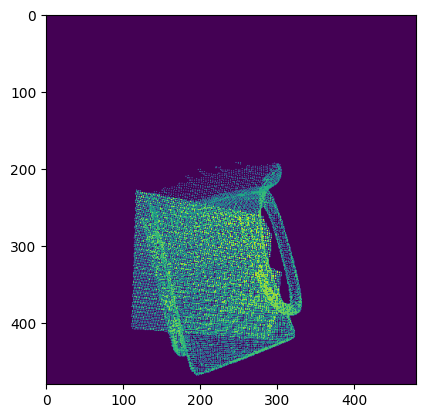

In [98]:
quality_error_roll = []

for e in tqdm(error):
    source_copy = copy.deepcopy(source) 
    source_copy.transform(refine_registration_result.transformation)

    source_copy.rotate(o3d.geometry.get_rotation_matrix_from_axis_angle([e, 0, 0]))
    I11, I12, I21, I22 = get_projections(target, np.identity(4), source_copy, np.linalg.inv(T), save=True)
    p = get_p(I11, I12, I21, I22, sigma=0.01)
    # print("Alignment Quality: ", p)
    quality_error_roll.append(p)


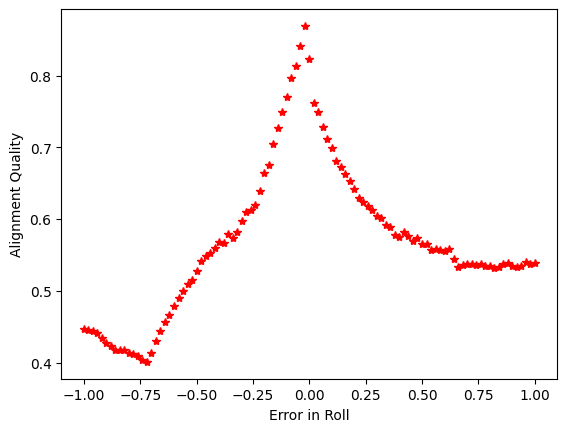

In [99]:
# Plot the results

plt.plot(error, quality_error_roll, 'r*')
plt.xlabel('Error in Roll')
plt.ylabel('Alignment Quality')
plt.show()

100%|██████████| 101/101 [04:33<00:00,  2.70s/it]


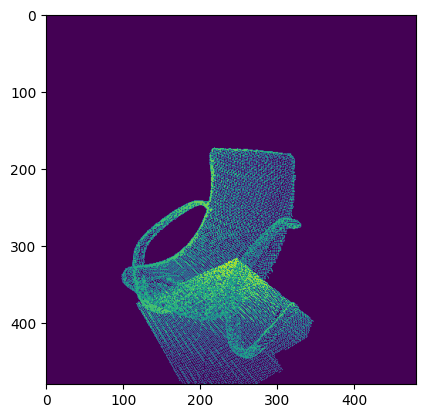

In [100]:
quality_error_pitch = []

for e in tqdm(error):
    source_copy = copy.deepcopy(source) 
    source_copy.transform(refine_registration_result.transformation)

    source_copy.rotate(o3d.geometry.get_rotation_matrix_from_axis_angle([0, e, 0]))
    I11, I12, I21, I22 = get_projections(target, np.identity(4), source_copy, np.linalg.inv(T), save=True)
    p = get_p(I11, I12, I21, I22, sigma=0.01)
    # print("Alignment Quality: ", p)
    quality_error_pitch.append(p)

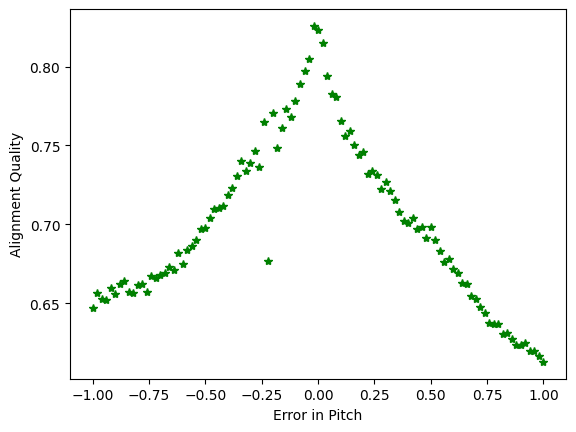

In [101]:
# Plot the results

plt.plot(error, quality_error_pitch, 'g*')
plt.xlabel('Error in Pitch')
plt.ylabel('Alignment Quality')
plt.show()

100%|██████████| 101/101 [04:34<00:00,  2.72s/it]


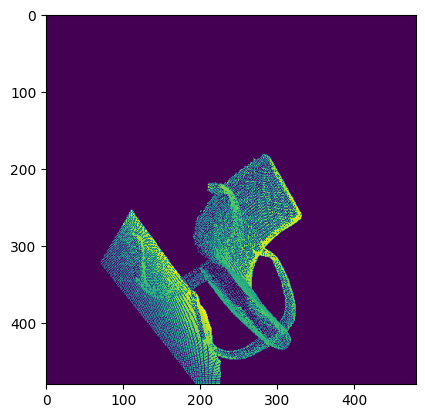

In [102]:
quality_error_yaw = []

for e in tqdm(error):
    source_copy = copy.deepcopy(source) 
    source_copy.transform(refine_registration_result.transformation)

    source_copy.rotate(o3d.geometry.get_rotation_matrix_from_axis_angle([0, 0, e]))
    I11, I12, I21, I22 = get_projections(target, np.identity(4), source_copy, np.linalg.inv(T), save=True)
    p = get_p(I11, I12, I21, I22, sigma=0.01)
    # print("Alignment Quality: ", p)
    quality_error_yaw.append(p)

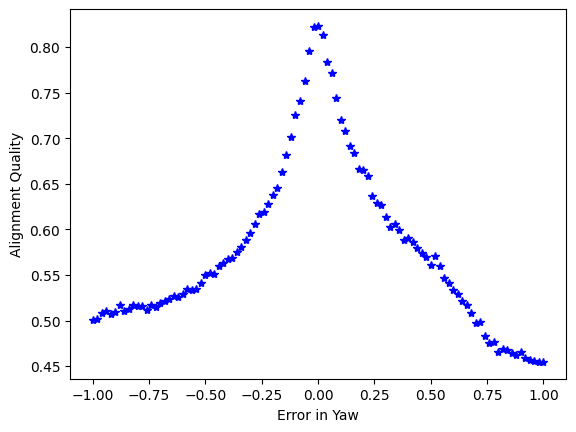

In [103]:
# Plot the results

plt.plot(error, quality_error_yaw, 'b*')
plt.xlabel('Error in Yaw')
plt.ylabel('Alignment Quality')
plt.show()

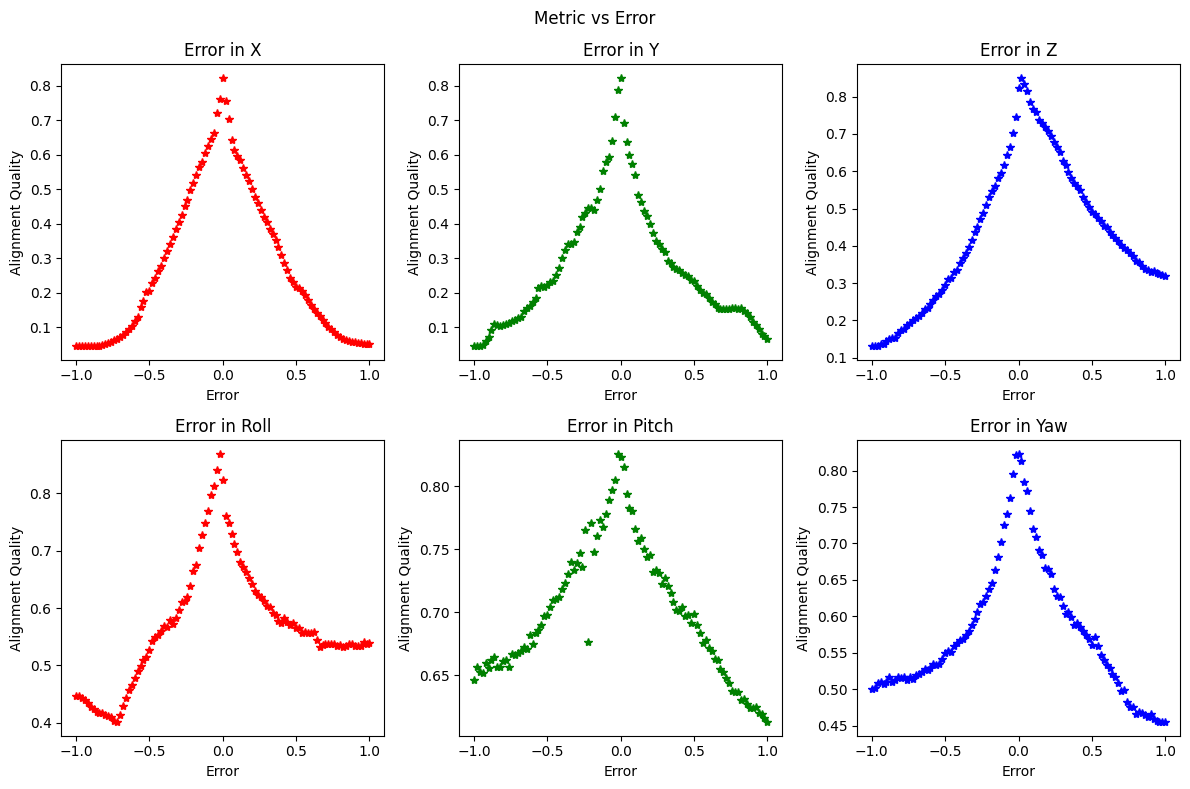

In [124]:
# Create a single plot for all the errors shown in different subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Metric vs Error')

axs[0, 0].plot(error, quality_error_x, 'r*')
axs[0, 0].set_title('Error in X')
# axs[0, 0].set_aspect('equal', adjustable='datalim')
axs[0, 1].plot(error, quality_error_y, 'g*')
axs[0, 1].set_title('Error in Y')
# axs[0, 1].set_aspect('equal', adjustable='datalim')
axs[0, 2].plot(error, quality_error_z, 'b*')
axs[0, 2].set_title('Error in Z')
# axs[0, 2].set_aspect('equal', adjustable='datalim')
axs[1, 0].plot(error, quality_error_roll, 'r*')
axs[1, 0].set_title('Error in Roll')
# axs[1, 0].set_aspect('equal', adjustable='datalim')
axs[1, 1].plot(error, quality_error_pitch, 'g*')
axs[1, 1].set_title('Error in Pitch')
# axs[1, 1].set_aspect('equal', adjustable='datalim')
axs[1, 2].plot(error, quality_error_yaw, 'b*')
axs[1, 2].set_title('Error in Yaw')
# axs[1, 2].set_aspect('equal', adjustable='datalim')

for ax in axs.flat:
    ax.set(xlabel='Error', ylabel='Alignment Quality')

fig.tight_layout()